**TensorBoard Model Summary using Pytorch**
---
1. How to use PyTorch with TensorBoard for tracking your deep learning project?
1. We will use colored CIFAR10 images.
1. How to correctly visualize colored images in TensorBoard?
1. How to track training loss and accuracy of your deep learning project using TensorBoard?

#### Installing Tensorboard

```bash
!pip install tensorboard
```



**1.Importing Modules**
---

In [54]:
# torch loaded...!!
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary

# torchvision loaded...!!
import torchvision
from torchvision import datasets, transforms

# other module loaded...!!
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm


Some of the important modules include:

* `SummaryWriter`: this is the TensorBoard module that PyTorch provides. We will be able to access all its functionalities after creating an object of SummaryWriter.
* `torchvision`: we can download PyTorch datasets and access the transforms using this module.
* `torch.nn`: provides all the neural network layers that we will need.

**2.Define Data Transformatiopn and prepare the Dataset**
---

In [29]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [30]:
# dataset downloaded...!!
trainset = datasets.CIFAR10(root='../data_cifar10', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='../data_cifar10', train=False, download=True, transform=transform)

# Data loader...!!
trainLoader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
testLoader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


**3.CIFAR 10 Classes**
---

In [31]:
classes = ['plane','car','bird','cat','deer','dog','frog','horse','ship','truck']

**4. Setting Up Tensorboard**
---

In [32]:
writer = SummaryWriter('runs/cifar10')

**5. Adding Images to tensorboard**
---

In [33]:
def show_img(image):
    image = image / 2 + 0.5
    npimage = image.numpy()
    plt.imshow(np.transpose(npimage, (1, 2, 0)))
    return npimage

* In the above show_img() function (takes an image tensor as a parameter), first, we unnormalize the images. 
* This is a very important step for TensorBoard visualization. If we do not unnormalize the images, then the images will be a lot noisy with random pixels. Then we convert the images to NumPy array and plot the images. 
* Finally, we return the unnormalized images. We return the image here, otherwise, we will again have to unnormalize them before passing them to add_img(). That would be a repetition of code and we want to avoid that.

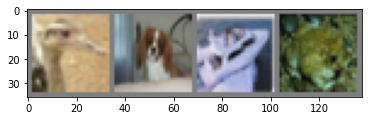

In [34]:
# get images
dataiter = iter(trainLoader)
images, labels = dataiter.next()

# create grid of images
img_grid = torchvision.utils.make_grid(images)

# get and show the unnormalized images
img_grid = show_img(img_grid)

# write to tensorboard
writer.add_image('Cifar10 Image', img_grid)

### Open the tensorboard in cmd

```bash
tensorboard --logdir=runs
```

**6.Define the Deep Neural Network Graph to Tensorboard**
---

In [48]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
net = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [1]:
summary(net, (3, 32, 32))

NameError: name 'summary' is not defined

In [51]:
# load the model into the device
writer.add_graph(net, images.to(device))
writer.close()

**7.Track Model training using tensorboard**
---

In [57]:
for epoch in range(10):
    running_loss = 0.0
    running_correct = 0
    with tqdm(trainLoader, unit="batch") as tepoch:
        for data in tepoch:
            tepoch.set_description(f"Epoch {epoch+1}")
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs.data, 1)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            running_correct += torch.sum(preds == labels.data)
            tepoch.set_postfix(loss=loss)  
            
        writer.add_scalar('loss', running_loss / len(trainLoader), epoch)
        writer.add_scalar('accuracy', running_correct.double() / len(trainLoader.dataset), epoch)
        print('epoch: {}, loss: {}, accuracy: {}'.format(epoch, running_loss / len(trainLoader), running_correct.double() / len(trainLoader.dataset)))
    print('Finished Training')

Epoch 1: 100%|██████████| 12500/12500 [03:27<00:00, 60.12batch/s, loss=tensor(0.5355, device='cuda:0', grad_fn=<NllLossBackward>)]


epoch: 0, loss: 1.3957625457572937, accuracy: 0.49612000000000006
Finished Training


Epoch 2: 100%|██████████| 12500/12500 [04:43<00:00, 44.12batch/s, loss=tensor(2.0570, device='cuda:0', grad_fn=<NllLossBackward>)]


epoch: 1, loss: 1.2268571854040027, accuracy: 0.5634
Finished Training


Epoch 3: 100%|██████████| 12500/12500 [04:19<00:00, 48.22batch/s, loss=tensor(1.9112, device='cuda:0', grad_fn=<NllLossBackward>)]


epoch: 2, loss: 1.1254645399177075, accuracy: 0.60074
Finished Training


Epoch 4: 100%|██████████| 12500/12500 [03:16<00:00, 63.74batch/s, loss=tensor(0.9148, device='cuda:0', grad_fn=<NllLossBackward>)] 


epoch: 3, loss: 1.0458213572911919, accuracy: 0.63166
Finished Training


Epoch 5: 100%|██████████| 12500/12500 [02:08<00:00, 97.57batch/s, loss=tensor(0.8473, device='cuda:0', grad_fn=<NllLossBackward>)] 


epoch: 4, loss: 0.9887139956446737, accuracy: 0.65242
Finished Training


Epoch 6: 100%|██████████| 12500/12500 [02:07<00:00, 97.87batch/s, loss=tensor(1.1014, device='cuda:0', grad_fn=<NllLossBackward>)]


epoch: 5, loss: 0.9419117592780665, accuracy: 0.6694000000000001
Finished Training


Epoch 7: 100%|██████████| 12500/12500 [02:24<00:00, 86.69batch/s, loss=tensor(1.2462, device='cuda:0', grad_fn=<NllLossBackward>)]


epoch: 6, loss: 0.9060661251644977, accuracy: 0.68042
Finished Training


Epoch 8: 100%|██████████| 12500/12500 [02:58<00:00, 70.09batch/s, loss=tensor(0.8456, device='cuda:0', grad_fn=<NllLossBackward>)]


epoch: 7, loss: 0.86699169231073, accuracy: 0.6929200000000001
Finished Training


Epoch 9: 100%|██████████| 12500/12500 [02:15<00:00, 92.03batch/s, loss=tensor(0.4044, device='cuda:0', grad_fn=<NllLossBackward>)] 


epoch: 8, loss: 0.8372248044571001, accuracy: 0.70494
Finished Training


Epoch 10: 100%|██████████| 12500/12500 [02:18<00:00, 90.12batch/s, loss=tensor(1.3713, device='cuda:0', grad_fn=<NllLossBackward>)] 

epoch: 9, loss: 0.8136869410972949, accuracy: 0.7133
Finished Training


**8.Tensorboard Results**
---

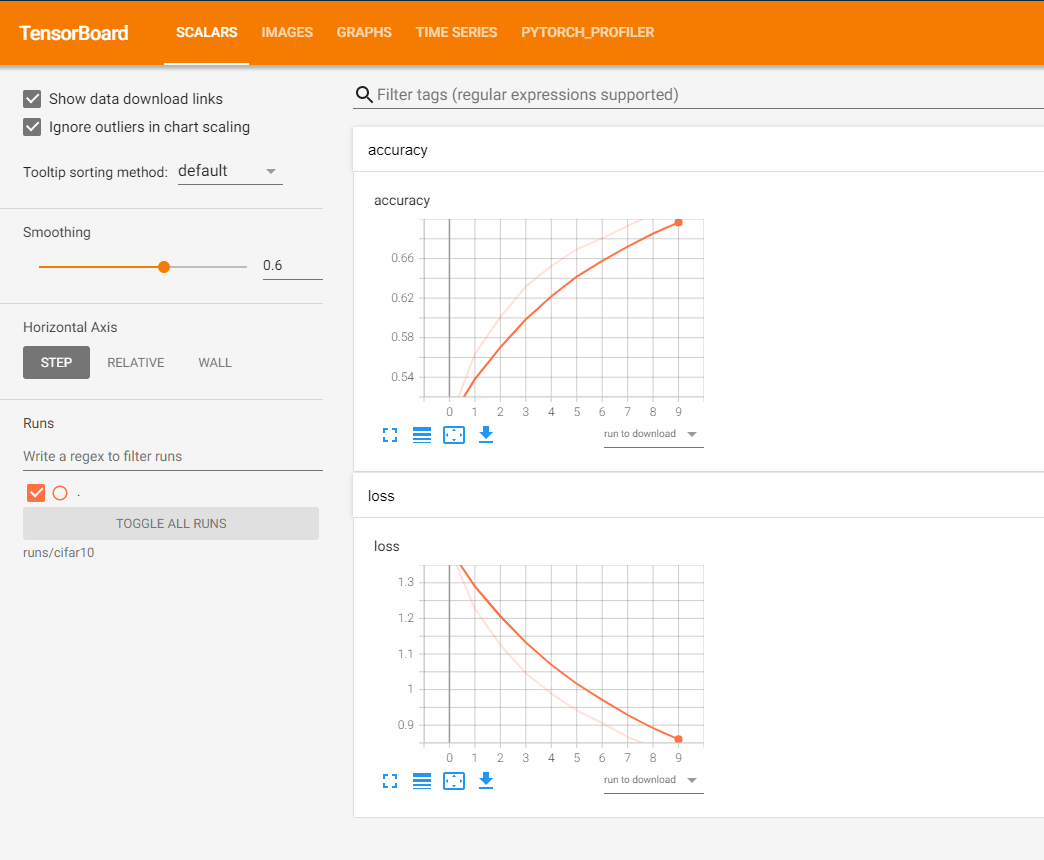

In [58]:
from IPython.display import Image
Image('Noise_image\Screenshot_2.png')